<a href="https://colab.research.google.com/github/antoniobelotti/gpu_aco_tsp/blob/master/bonaiuti_sandro93_gmail_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Nov 23 15:29:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


#Setup

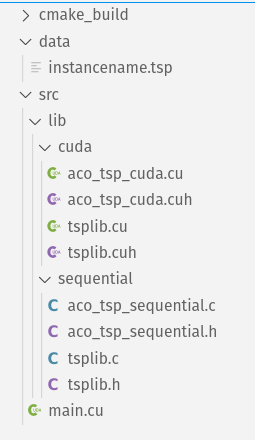

In [ ]:
# Comment this to enable output
%%capture 

# remove default colab stuff
!rm -rf sample_data 

#create directory structure
!mkdir -p src/lib/cuda
!mkdir -p src/lib/sequential

# download TSPLIB intsances
!git clone https://github.com/mastqe/tsplib.git data

# Install nvcc colab plugin
!pip install git+https://github.com/andreinechaev/nvcc4jupyter
%load_ext nvcc_plugin

#Code

##Sequential implementation

###Code to read TSPLIB instances





In [ ]:
%%cuda --name lib/sequential/tsplib.h
#ifndef TSPLIB_H
#define TSPLIB_H

#define ASCII_SLASH 47
#define ASCII_0 48
#define ASCII_9 57

typedef struct node_t{
    int id;
    int x;
    int y;
} Node;

typedef struct TSPInstance_t {
    const int numOfNodes;
    Node *nodes;
    double *edgeCosts;
} TSPInstance;


TSPInstance tsp_instance_read(const char *filename);
void tsp_instance_free(TSPInstance *instance);

#endif //TSPLIB_H

'File written in /content/src/lib/sequential/tsplib.h'

In [ ]:
%%cuda --name lib/sequential/tsplib.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>

#include "tsplib.h"


TSPInstance tsp_instance_read(const char *filename) {
    printf("Reading tsplib instances from %s\n", filename);

    FILE *f = fopen(filename, "r");
    if (f == NULL) {
        printf("Error reading file!");
        exit(1);
    }

    unsigned long filename_len = strlen(filename);
    const char *s = filename + filename_len; // pointer to last char
    for (; *s != ASCII_SLASH; s--); // scan backwards until / is found
    for (; *s < ASCII_0 || *s > ASCII_9; s++); // scan forward until a digit is found

    int num_of_nodes = strtol(s, NULL, 10);

    char line_buff[64];
    Node *nodes = malloc(sizeof *nodes * num_of_nodes);

    while (fgets(line_buff, sizeof line_buff, f) != NULL &&
           strncmp(line_buff, "NODE_COORD_SECTION", strlen("NODE_COORD_SECTION")) != 0);

    while (fgets(line_buff, sizeof line_buff, f) != NULL && strncmp(line_buff, "EOF", 3) != 0) {

        int progr, x, y;

        char *buff_cursor;
        progr = strtol(line_buff, &buff_cursor, 10);
        x = strtol(buff_cursor, &buff_cursor, 10);
        y = strtol(buff_cursor, &buff_cursor, 10);

        // convert to 0-indexed
        progr -= 1;

        nodes[progr].id = progr;
        nodes[progr].x = x;
        nodes[progr].y = y;

    }

    fclose(f);

    TSPInstance instance = {.numOfNodes = num_of_nodes, .nodes = nodes};

    double *edge_cost = malloc(sizeof(double) * num_of_nodes * num_of_nodes);

    double deltaX, deltaY, weight;
    Node n1, n2;
    for (int i = 0; i < num_of_nodes; i++) {
        for (int j = i; j < num_of_nodes; j++) {
            n1 = nodes[i];
            n2 = nodes[j];

            deltaX = (double) (n1.x - n2.x);
            deltaY = (double) (n1.y - n2.y);

            weight = floor(sqrt(pow(deltaX, 2) + pow(deltaY,2)));

            // different nodes in the same position. Set very small distance 
            // instead of 0 to prevent math errors later
            if(weight == 0 && i != j)
              weight = pow(1, -50);

            edge_cost[n1.id * num_of_nodes + n2.id] = weight;
            edge_cost[n2.id * num_of_nodes + n1.id] = weight;
        }
    }
    instance.edgeCosts = edge_cost;
    return instance;
}

void tsp_instance_free(TSPInstance *instance) {
    free(instance->nodes);
    free(instance->edgeCosts);
}

'File written in /content/src/lib/sequential/tsplib.cu'

In [ ]:
!mv src/lib/sequential/tsplib.cu src/lib/sequential/tsplib.c

###Algorithm

In [ ]:
%%cuda --name lib/sequential/aco_tsp_sequential.h
#ifndef ACO_TSP_SEQUENTIAL_H
#define ACO_TSP_SEQUENTIAL_H

#include "tsplib.h"

void aco_tsp_sequential(
    TSPInstance instance,
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
);

#endif // ACO_TSP_SEQUENTIAL_H

'File written in /content/src/lib/sequential/aco_tsp_sequential.h'

In [ ]:
# cuda plugin requires .cu extension... change it later to .c
# using %%cuda instead of %%writefile becaus writefile disables syntax highlighting

%%cuda --name lib/sequential/aco_tsp_sequential.cu
#include <stdio.h>
#include <limits.h>
#include <stdbool.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

#include "aco_tsp_sequential.h"

double randf(double right) {
    return ((double) rand() / (double) RAND_MAX) * right;
}

void pheromone_initialization(double *pheromones, const double *edge_cost, int N) {
    /* BUILD greedy path */
    int path[N];
    double path_cost = 0;
    bool visited[N];

    int id_first_node = (int) random() % N;
    visited[id_first_node] = true;

    int current_node = id_first_node;
    for (int i = 1; i < N; i++) {
        int closest_node = -1;
        double closest_node_cost = (double) INT_MAX;

        for (int j = 0; j < N; ++j) {
            if (!visited[j] && current_node != j && edge_cost[current_node * N + j] < closest_node_cost) {
                closest_node_cost = edge_cost[current_node * N + j];
                closest_node = j;
            }
        }

        path[current_node] = closest_node;
        visited[closest_node] = true;
        current_node = closest_node;
        path_cost += closest_node_cost;
    }

    /* set pheromone to N/greedy path cost */
    for (int i = 0; i < N * N; ++i)
        pheromones[i] = (double) N / (double) path_cost;
}

void build_paths(int *ant_paths_mx, double *pheromone_trails, double *edge_costs, int N, const double ALPHA, const double BETA) {
    for (int i = 0; i < N * N; i++) ant_paths_mx[i] = -1;

    bool *unvisited_nodes_mx = malloc(sizeof *unvisited_nodes_mx * N * N);
    for (int i = 0; i < N * N; i++) unvisited_nodes_mx[i] = true;

    double *edge_fitness_mx = malloc(sizeof *edge_fitness_mx *N * N);
    for (int r = 0; r < N; ++r)
      for (int c = 0; c < N; ++c)
        edge_fitness_mx[r * N + c] =
          r == c ? 0 : powf(pheromone_trails[r * N + c], ALPHA) / powf(edge_costs[r * N + c], BETA);

    // build every ant's path
    for (int ant_id = 0; ant_id < N; ++ant_id) {
        // select random starting node
        int id_first_node = (int) random() % N;
        unvisited_nodes_mx[ant_id * N + id_first_node] = false;

        int current_node_id = id_first_node;
        for (int visited_nodes = 1; visited_nodes < N; visited_nodes++) {
            double prefix_sum[N];
            for (int j = 0; j < N; j++) {
                bool mask = unvisited_nodes_mx[ant_id * N + j];
                double fitness = edge_fitness_mx[current_node_id * N + j];
                prefix_sum[j] = (j > 0 ? prefix_sum[j - 1] : 0.0f) + ((double) mask * fitness);
            }

            double random_number = randf(prefix_sum[N - 1]);
            for (int j = 0; j < N; ++j) {
                double ps_prev = j > 0 ? prefix_sum[j - 1] : 0.0f;
                if (random_number >= ps_prev && random_number < prefix_sum[j]) {
                    ant_paths_mx[ant_id * N + current_node_id] = j;
                    unvisited_nodes_mx[ant_id * N + j] = false;
                    current_node_id = j;
                    break;
                }
            }
        }

        ant_paths_mx[ant_id * N + current_node_id] = id_first_node;
    }

    free(edge_fitness_mx);
    free(unvisited_nodes_mx);
}

int update_paths_len(const int *ant_paths_mx, double *ant_paths_len, const double *edge_cost, int N) {
    // keep track of the ant id with the shortest path
    int best_path_ant_id = -1;
    double best_path = (double) INT_MAX;

    for (int ant_id = 0; ant_id < N; ++ant_id) {
        // calculate cost of ant(ant_id) path
        ant_paths_len[ant_id] = 0;
        int current_node = 0;
        int next_node = ant_paths_mx[ant_id * N + current_node];

        for (int i = 0; i < N; ++i) {
            ant_paths_len[ant_id] += edge_cost[current_node * N + next_node];
            current_node = next_node;
            next_node = ant_paths_mx[ant_id * N + current_node];
        }

        if (ant_paths_len[ant_id] < best_path) {
            best_path = ant_paths_len[ant_id];
            best_path_ant_id = ant_id;
        }
    }

    return best_path_ant_id;
}

void pheromone_evaporation(double *pheromones, int N, const double RHO, const double PHEROMONE_LB) {
    for (int i = 0; i < N * N; ++i)
        pheromones[i] = fmaxf((1 - RHO) * pheromones[i], PHEROMONE_LB);
}

void pheromone_update(double *pheromones, const int *paths, const double *paths_len, int N, const double Q, const double PHEROMONE_LB) {
    for (int i = 0; i < N; ++i) {
        for (int j = i; j < N; ++j) {
            double previous_pheromone_value = pheromones[i * N + j];
            double addition = 0.0f;
            for (int ant_id = 0; ant_id < N; ++ant_id)
                // if edge (i,j) is in path of ant ant_id
                if (paths[ant_id * N + i] == j)
                    addition += Q / (double) paths_len[ant_id];


            pheromones[i * N + j] = fmaxf(previous_pheromone_value + addition, PHEROMONE_LB);
        }
    }
}

void aco_tsp_sequential(
    TSPInstance instance,
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
)
{
    int N = instance.numOfNodes;
    double *pheromone_mx = malloc(sizeof *pheromone_mx * N * N);
    int   *paths_mx = malloc(sizeof *paths_mx *N * N);
    double paths_len[N];
    int best_path[N];
    double best_path_len = (double) INT_MAX;

    pheromone_initialization(pheromone_mx, instance.edgeCosts, N);

    int stagnationsLeft = STAGNATION_THRESHOLD;
    int iterationsLeft = MAX_ITERATIONS;
    while(iterationsLeft-->0 && stagnationsLeft-->0){
        printf("\tGeneration %d of %d", MAX_ITERATIONS-iterationsLeft, MAX_ITERATIONS);
        fflush(stdout);
      
        build_paths(paths_mx, pheromone_mx, instance.edgeCosts, N, ALPHA, BETA);
        int current_iteration_best_ant = update_paths_len(paths_mx, paths_len, instance.edgeCosts, N);

        pheromone_evaporation(pheromone_mx, N, RHO, PHEROMONE_LB);
        pheromone_update(pheromone_mx, paths_mx, paths_len, N, Q, PHEROMONE_LB);

        if (paths_len[current_iteration_best_ant] < best_path_len) {
            best_path_len = paths_len[current_iteration_best_ant];

            // save best path
            for (int l = 0; l < instance.numOfNodes; ++l)
                best_path[l] = paths_mx[current_iteration_best_ant * N + l];

            // there's an improvement reset stagnation counter
            stagnationsLeft = STAGNATION_THRESHOLD;
        }

        printf("\r");
        fflush(stdout);
    }
    
    free(pheromone_mx);
    free(paths_mx);
    
    char *prefix = stagnationsLeft == -1 ? "Stopped for stagnation!\n\t" : "";
    printf("\n\t%sAfter %d iterations, best Path has len: %f\n", prefix, MAX_ITERATIONS-iterationsLeft-1, best_path_len);
    
    printf("\t");
    for (int j = 0; j < instance.numOfNodes; ++j) printf("%d,", best_path[j] + 1);
    printf("\n");
    fflush(stdout);
}


'File written in /content/src/lib/sequential/aco_tsp_sequential.cu'

In [ ]:
!mv /content/src/lib/sequential/aco_tsp_sequential.cu /content/src/lib/sequential/aco_tsp_sequential.c

##GPU implementation

In [ ]:
%%cuda --name lib/cuda/common.h
#include <sys/time.h>
#include <stdio.h>

#ifndef _COMMON_H
#define _COMMON_H

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

#define CHECK_CURAND(call)                                                     \
{                                                                              \
    curandStatus_t err;                                                        \
    if ((err = (call)) != CURAND_STATUS_SUCCESS)                               \
    {                                                                          \
        fprintf(stderr, "Got CURAND error %d at %s:%d\n", err, __FILE__,       \
                __LINE__);                                                     \
        exit(1);                                                               \
    }                                                                          \
}

#endif // _COMMON_H

'File written in /content/src/lib/cuda/common.h'

### Algorithm

In [ ]:
%%cuda --name lib/cuda/aco_tsp_cuda.h
#ifndef ACO_TSP_CUDA_H
#define ACO_TSP_CUDA_H

#include <curand_kernel.h>

#include "../sequential/tsplib.h"
#include "./common.h"

#define DIV_ROUNDUP(NUM,DEN) ((NUM +(DEN-1))/DEN)

void aco_tsp_cuda(
    TSPInstance instance, 
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
);

#endif // ACO_TSP_CUDA_H

'File written in /content/src/lib/cuda/aco_tsp_cuda.h'

In [ ]:
%%cuda --name lib/cuda/aco_tsp_cuda.cu

#include <stdio.h>
#include <iostream>
#include <assert.h>
#include <thrust/scan.h>
#include <thrust/sort.h>
#include <thrust/execution_policy.h>

#include "aco_tsp_cuda.h"

typedef enum {
    SCAN_INCLUSIVE, SCAN_EXCLUSIVE
} PRESCAN_TYPE_ENUM;

__constant__ float Q;
__constant__ float RHO;
__constant__ float ALPHA;
__constant__ float BETA;
__constant__ float PHEROMONE_LB;


__global__ void init_random_states(curandState *randStates, const int RAND_STATE_SIZE) {
  const int GTID = blockIdx.x * blockDim.x + threadIdx.x;

  if (GTID < RAND_STATE_SIZE)
    curand_init(GTID, 100, 0, &randStates[GTID]);
}

__global__ void select_starting_position(
    bool *unvisited_nodes_mx,
    int *ant_first_node,
    int *ant_current_position,
    curandState *randStates,
    const int N
) {
  const int antId = blockIdx.x * blockDim.x + threadIdx.x;

  if (antId >= N)
    return;

  // abs is necessary because rand returns unsigned, and casting to signed results in overflow, which gives a negative number
  const int randomNodeId = abs((int) curand(&randStates[antId]) % N);
  ant_first_node[antId] = randomNodeId;
  ant_current_position[antId] = randomNodeId;
  unvisited_nodes_mx[antId * N + randomNodeId] = false;

}

__global__ void edge_fitness_update(
    double *fitnessMX,
    double *pheromoneMX,
    double *edgeCostsMX,
    const int N
) {
  const int GTID = blockIdx.x * blockDim.x + threadIdx.x;
  if (GTID >= N * N)
    return;

  const double edgeCost = edgeCostsMX[GTID];
  const double pheromone = pheromoneMX[GTID];

  // avoid math error
  if (edgeCost == 0 || pheromone == 0)
    fitnessMX[GTID] = 0.0f;
  else
    fitnessMX[GTID] = powf(pheromone, ALPHA) / powf(edgeCost, BETA);
}


/*
* cell (x,y) in originalFitness is the fitness from node x to node y
* apply mask produces output, in which cell (x,y) is the fitness for ant x from ant(x) current position to node y
*/
__global__ void apply_mask(double *output, double *originalFitness, bool *mask, int *antsCurrentPosition, const int N) {
  const int GTID = blockIdx.x * blockDim.x + threadIdx.x;

  if (GTID >= N * N)
    return;

  const int antId = GTID / N;
  const int from = antsCurrentPosition[antId];
  const int to = GTID % N;

  output[GTID] = mask[GTID] * originalFitness[from * N + to];
}

__global__ void select_node(
    double *fitnessMX,
    double *randomNumbers,
    int *antPathsMx,
    bool *unvisitedNodesMX,
    int *antsCurrentPosition,
    double *pathsCost,
    double *edgeCostsMX,
    const int N
) {
  const int GTID = blockDim.x * blockIdx.x + threadIdx.x;

  if (GTID >= N * N)
    return;

  const int antId = GTID / N;
  const int colId = GTID % N;
  const double randNum = randomNumbers[antId];

  const double prev = colId > 0 ? fitnessMX[GTID - 1] : 0.0f;
  const double curr = fitnessMX[GTID];

  // for the properties of the prefix sum and the range of the random number,
  // only one thread will enter this if
  if (randNum >= prev && randNum < curr) {
    const int currPos = antsCurrentPosition[antId];
    const int selectedNodeId = colId;

    // add edge (currPos ---> selectedNode)
    antPathsMx[antId * N + currPos] = selectedNodeId;

    // set node as visited
    unvisitedNodesMX[antId * N + selectedNodeId] = false;

    // update ant current position
    antsCurrentPosition[antId] = selectedNodeId;

    //update current ant path cost
    pathsCost[antId] += edgeCostsMX[currPos * N + selectedNodeId];
  }
}

__global__ void pheromone_evaporation(double *pheromoneMX, const int N) {
  const int GTID = blockIdx.x * blockDim.x + threadIdx.x;

  if (GTID < N * N)
    pheromoneMX[GTID] = fmaxf((1 - RHO) * pheromoneMX[GTID], PHEROMONE_LB);
}

__global__ void generate_random_number_in_range(double *fitnessMX, double *antsRandomNums, curandState *randState, const int N) {
  const int antId = blockIdx.x * blockDim.x + threadIdx.x;

  if (antId >= N)
    return;

  const double max = fitnessMX[antId * N + (N - 1)];
  const double min = fitnessMX[antId * N];

  assert(max > 0.0f && "Range given is [0,0). This should not be possible (prescan always has one value >0)\n");

  if (max == min) {
    antsRandomNums[antId] = min;
    return;
  }

  // in a loop because the range is right-exclusive. so in the case r==maxVal it generates another num
  double r = max;
  while (r == max)
    r = (max - min) * (curand_uniform_double(&randState[antId])) + min;
  
  antsRandomNums[antId] = r;
}

__global__ void close_loop(int *antPaths, int *firstNodes, int *currentPosition, const int N) {
  const int antId = blockDim.x * blockIdx.x + threadIdx.x;

  if (antId >= N)
    return;

  const int current = currentPosition[antId];
  const int first = firstNodes[antId];

  antPaths[antId * N + current] = first;
}

__global__ void precompute_pheromone_increments(double *increments, double *pathsCosts, const int N) {
  const int antId = blockDim.x * blockIdx.x + threadIdx.x;

  if (antId < N)
    increments[antId] = Q / pathsCosts[antId];
}


/*
https://stackoverflow.com/a/39287554
to avoid compilation error on atomicAdd for double type
*/
#if defined(__CUDA_ARCH__) && __CUDA_ARCH__ < 600
static __inline__ __device__ double atomicAdd(double *address, double val) {
  unsigned long long int* address_as_ull = (unsigned long long int*)address;
  unsigned long long int old = *address_as_ull, assumed;
  if (val==0.0)
    return __longlong_as_double(old);
  do {
    assumed = old;
    old = atomicCAS(address_as_ull, assumed, __double_as_longlong(val +__longlong_as_double(assumed)));
  } while (assumed != old);
  return __longlong_as_double(old);
}
#endif

__global__ void pheromone_update_atomic(double *pheromone_mx, int *paths_mx, double *increments, int N) {
  const int GTID = blockDim.x * blockIdx.x + threadIdx.x;

  if (GTID >= N * N)
    return;

  const int antId = GTID / N;
  const int from = GTID % N;
  const int to = paths_mx[GTID];

  atomicAdd(&pheromone_mx[from * N + to], increments[antId]);
}

/*
  prescan (in-place)
  --------------------------------------------------------------------------------
  Tree-based algorithm for inclusive scan.

  LAUNCH PARAMETERS:
    Having N elements. Block size = B:
      ceil(N/B)   blocks
      b/2         threads
      (N/B)+1     doubles in shared memory
  PARAMETERS:
    *data             array to prefix sum
    BLOCKSIZE         number of elements in each block
    *intermediateSum  output of each block final sum. Used to calculate prescan with multiple blocks.
    SCAN_TYPE         flag to specify is sum is inlcusive or exclusive
    ARRSIZE           number of elements in the entire array
*/
__global__ void prescan(
    double *data,
    const int BLOCKSIZE,
    double *intermediateSum,
    const PRESCAN_TYPE_ENUM SCAN_TYPE,
    const int ARRSIZE) {

  extern __shared__ double sm_data[];

  const int TID = threadIdx.x;
  const int GTID = blockIdx.x * blockDim.x + threadIdx.x;
  int offset = 1;

  /* Load input into shared memory. Threads that exceed the actual array size
  *  load a zero, so they do not influence the correct scan result.
  */
  sm_data[2 * TID] = (2 * GTID < ARRSIZE) ? data[2 * GTID] : 0;
  sm_data[2 * TID + 1] = (2 * GTID + 1 < ARRSIZE) ? data[2 * GTID + 1] : 0;

  // upsweeep: build block-sum in place up the tree
  for (int d = BLOCKSIZE >> 1; d > 0; d >>= 1) {
    __syncthreads();

    if (TID < d) {
      int ai = offset * (2 * TID + 1) - 1;
      int bi = offset * (2 * TID + 2) - 1;
      sm_data[bi] += sm_data[ai];
    }
    offset *= 2;
  }

  /* first thread of the block is in charge of storing the block sum into an intermediate result
   * and setting the last element of shared memory to 0 for the downsweep
   */
  if (TID == 0) {
    if (intermediateSum != NULL)
      intermediateSum[blockIdx.x] = sm_data[BLOCKSIZE - 1];

    if (SCAN_TYPE == SCAN_INCLUSIVE)
      sm_data[BLOCKSIZE] = sm_data[BLOCKSIZE - 1];

    sm_data[BLOCKSIZE - 1] = 0.0f;
  }

  // downsweep: traverse down tree & build scan
  for (int d = 1; d < BLOCKSIZE; d *= 2) {
    offset >>= 1;
    __syncthreads();
    if (TID < d) {
      int ai = offset * (2 * TID + 1) - 1;
      int bi = offset * (2 * TID + 2) - 1;
      double t = sm_data[ai];
      sm_data[ai] = sm_data[bi];
      sm_data[bi] += t;
    }
  }

  __syncthreads();

  int shift = SCAN_TYPE == SCAN_INCLUSIVE;

  if (2 * GTID < ARRSIZE)
    data[2 * GTID] = sm_data[2 * TID + shift];
  if (2 * GTID + 1 < ARRSIZE)
    data[2 * GTID + 1] = sm_data[2 * TID + 1 + shift];
}

__global__ void apply_increment(double *cumsum, double *increment, const int ARR_SIZE) {
  int gidx = blockIdx.x * blockDim.x + threadIdx.x;

  if (gidx < ARR_SIZE)
    cumsum[gidx] += increment[blockIdx.x];
}

int next_power_of_two(int n) {
  assert(n >= 0);
  
  int res = 1;
  while (res < n) { res <<= 1; }
  return res;
}

int next_multiple_of(int numToRound, int multiple) {
  assert(numToRound > 0);
  assert(multiple > 0);

  int remainder = numToRound % multiple;
  if (remainder == 0)
    return numToRound;

  return numToRound + multiple - remainder;
}

void prescan_launcher(double *d_v, const int ARR_SIZE, const PRESCAN_TYPE_ENUM SCAN_TYPE, const int MAX_BLOCK_SIZE) {
  /* 
  *  Blocksize needs to be a power of two because the scan builds a binary tree. Blocksizes
  *  of different sizes will result in illegal memory accesses.
  */
  int blockSize = MAX_BLOCK_SIZE;
  int numBlocks = DIV_ROUNDUP(ARR_SIZE, blockSize);
  // 40 is number of SM on gpu
  //while(numBlocks<40 && blockSize > 32){
  //  blockSize /= 2;
  //  numBlocks = DIV_ROUNDUP(ARR_SIZE, blockSize);
  //}
  const int threadsPerBlock = blockSize / 2;

  double *d_intermediary_sums;
  CHECK(cudaMalloc((void **) &d_intermediary_sums, sizeof(double) * numBlocks));

  prescan<<<numBlocks, threadsPerBlock, sizeof(double) * (blockSize + 1)>>>(d_v, blockSize, d_intermediary_sums,
                                                                            SCAN_TYPE, ARR_SIZE);

  if (numBlocks > 1) {
    if (numBlocks <= MAX_BLOCK_SIZE) {
      // last pass, sum on intermediate values
      prescan<<<1, threadsPerBlock, sizeof(double) * blockSize>>>(d_intermediary_sums, blockSize, NULL,
                                                                  SCAN_EXCLUSIVE, numBlocks);
    } else if (numBlocks > MAX_BLOCK_SIZE) {
      // cannot sum intermediate values in just one block. Need to do multiple passes, recursively...
      prescan_launcher(d_intermediary_sums, numBlocks, SCAN_EXCLUSIVE, MAX_BLOCK_SIZE);
    }

    apply_increment<<<numBlocks, threadsPerBlock * 2>>>(d_v, d_intermediary_sums, ARR_SIZE);
  }

  CHECK(cudaFree(d_intermediary_sums));
}

void pheromone_initialization(double *pheromones, double *edge_cost, int N) {
  /* BUILD greedy path */
  double path_cost = 0;
  bool visited[N];

  int id_first_node = (int) random() % N;
  visited[id_first_node] = true;

  int current_node = id_first_node;
  for (int i = 1; i < N; i++) {
    int closest_node = -1;
    double closest_node_cost = (double) INT_MAX;

    for (int j = 0; j < N; ++j) {
      if (!visited[j] && current_node != j && edge_cost[current_node * N + j] < closest_node_cost) {
        closest_node_cost = edge_cost[current_node * N + j];
        closest_node = j;
      }
    }

    visited[closest_node] = true;
    current_node = closest_node;
    path_cost += closest_node_cost;
  }

  /* set pheromone to N/greedy path cost */
  for (int i = 0; i < N * N; ++i)
    pheromones[i] = (double) N / (double) path_cost;
}

__global__ void
update_best_path_data(int *d_indexes, double *d_pathsCosts, int *d_pathsMx, int *d_bestPath, double *d_bestPathLen,
                      const int N) {
  const int GTID = blockIdx.x * blockDim.x + threadIdx.x;

  __shared__ double sm_previousBestCost;
  __shared__ double sm_currentBestCost;
  __shared__ int sm_bestAntId;

  if (GTID >= N)
    return;

  if (threadIdx.x == 0) {
    sm_previousBestCost = d_bestPathLen[0];
    sm_currentBestCost = d_pathsCosts[0];
    sm_bestAntId = d_indexes[0];
  }
  __syncthreads();

  if (sm_previousBestCost <= sm_currentBestCost)
    return;

  // save best path
  d_bestPath[GTID] = d_pathsMx[sm_bestAntId * N + GTID];

  if (GTID == 0)
    d_bestPathLen[0] = sm_currentBestCost;
}

__global__ void elevate_edge_costs_to_beta(double *out, double *in, const int N) {
  const int GTID = blockIdx.x * blockDim.x + threadIdx.x;

  if (GTID >= N * N)
    return;

  out[GTID] = powf(in[GTID], BETA);
}


void aco_tsp_cuda(
    TSPInstance instance,
    const float h_ALPHA,
    const float h_BETA,
    const float h_RHO,
    const float h_Q,
    const float h_PHEROMONE_LB,
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
) {
  int deviceCount = 0;
  CHECK(cudaGetDeviceCount(&deviceCount));
  assert(deviceCount > 0 && "There are no available device(s) that support CUDA");
  cudaSetDevice(0);


  CHECK(cudaMemcpyToSymbol(ALPHA, &h_ALPHA, sizeof(float)));
  CHECK(cudaMemcpyToSymbol(BETA, &h_BETA, sizeof(float)));
  CHECK(cudaMemcpyToSymbol(RHO, &h_RHO, sizeof(float)));
  CHECK(cudaMemcpyToSymbol(Q, &h_Q, sizeof(float)));
  CHECK(cudaMemcpyToSymbol(PHEROMONE_LB, &h_PHEROMONE_LB, sizeof(float)));

  /* instance size defines size of most data structures (arrays and matrices). N is also the number of ants */
  const int N = instance.numOfNodes;

  const int NN_INT_SIZE = sizeof(int) * N * N,
      NN_double_SIZE = sizeof(double) * N * N,
      NN_BOOL_SIZE = sizeof(bool) * N * N,
      N_INT_SIZE = sizeof(int) * N,
      N_double_SIZE = sizeof(double) * N;

  cudaDeviceProp deviceProp;
  CHECK(cudaGetDeviceProperties(&deviceProp, 0));

  const int MAX_BLOCK_SIZE = deviceProp.maxThreadsDim[0];
  const int NUMBER_OF_SM = deviceProp.multiProcessorCount;


  /* configuration for kernels requiring N total threads */
  int N_Op_NumThreads = 64;
  int N_Op_NumBlocks = DIV_ROUNDUP(N, N_Op_NumThreads);
  while (N_Op_NumThreads < MAX_BLOCK_SIZE && N_Op_NumBlocks < NUMBER_OF_SM) {
    N_Op_NumThreads += 32;
    N_Op_NumBlocks = DIV_ROUNDUP(N, N_Op_NumThreads);
  }

  /* configuration for kernels requiring N*N total threads */
  int NN_Op_NumThreads = 256;
  int NN_Op_NumBlocks = DIV_ROUNDUP(N * N, NN_Op_NumThreads);
  while (NN_Op_NumThreads < MAX_BLOCK_SIZE && NN_Op_NumBlocks < NUMBER_OF_SM) {
    NN_Op_NumThreads += 32;
    NN_Op_NumBlocks = DIV_ROUNDUP(N * N, NN_Op_NumThreads);
  }

  double h_pathsCosts[N];
  int h_bestPath[N];
  double h_bestPathLen = DBL_MAX;


  /* DEVICE */
  double *d_pheromoneMX,
      *d_edgeCostsMX,
      *d_edgeFitnessMX,
      *d_fitnessPrescanMX,
      *d_pathsCosts,
      *d_randomNumbers,
      *d_pheromoneIncrements;

  int *d_pathsMX,
      *d_antsFirstNode,
      *d_antsCurrentPosition;

  bool *d_unvisitedNodesMX;

  curandState *d_randStates;

  /* NxN size */
  CHECK(cudaMalloc((void **) &d_pheromoneMX, NN_double_SIZE));
  CHECK(cudaMalloc((void **) &d_pathsMX, NN_INT_SIZE));
  CHECK(cudaMalloc((void **) &d_edgeCostsMX, NN_double_SIZE));
  CHECK(cudaMalloc((void **) &d_edgeFitnessMX, NN_double_SIZE));
  CHECK(cudaMalloc((void **) &d_fitnessPrescanMX, NN_double_SIZE));
  CHECK(cudaMalloc((void **) &d_unvisitedNodesMX, NN_BOOL_SIZE));

  /* 1xN size */
  CHECK(cudaMalloc((void **) &d_antsCurrentPosition, N_INT_SIZE));
  CHECK(cudaMalloc((void **) &d_antsFirstNode, N_INT_SIZE));
  CHECK(cudaMalloc((void **) &d_randomNumbers, N_double_SIZE));
  CHECK(cudaMalloc((void **) &d_pathsCosts, N_double_SIZE));
  CHECK(cudaMalloc((void **) &d_pheromoneIncrements, N_double_SIZE));
  CHECK(cudaMalloc((void **) &d_randStates, N * sizeof(curandState)));

  /*** INITIALIZATION ******/
  // PHEROMONES
  double *startingPheromones = (double *) malloc(NN_double_SIZE);
  pheromone_initialization(startingPheromones, instance.edgeCosts, N);
  CHECK(cudaMemcpy(d_pheromoneMX, startingPheromones, NN_double_SIZE, cudaMemcpyHostToDevice));
  free(startingPheromones);

  // EDGES COSTS
  CHECK(cudaMemcpy(d_edgeCostsMX, instance.edgeCosts, NN_double_SIZE, cudaMemcpyHostToDevice));

  // RANDOM STATES FOR CURAND
  init_random_states<<<N_Op_NumBlocks, N_Op_NumThreads>>>(d_randStates, N);

  int currentIterationBestAntId;
  int stagnationsLeft = STAGNATION_THRESHOLD;
  int iterationsLeft = MAX_ITERATIONS;
  while (iterationsLeft-- > 0 && stagnationsLeft-- > 0) {
    printf("\tGeneration %d of %d", MAX_ITERATIONS - iterationsLeft, MAX_ITERATIONS);
    fflush(stdout);

    /* reset (or update) all data from previous iteration */
    CHECK(cudaMemset(d_pathsCosts, 0, N_double_SIZE));
    CHECK(cudaMemset(d_unvisitedNodesMX, 1,
                     NN_BOOL_SIZE));  // set EACH BYTE to 1. Works anyway because any number != 0 is true.

    select_starting_position<<<N_Op_NumBlocks, N_Op_NumThreads>>>(
        d_unvisitedNodesMX,
        d_antsFirstNode,
        d_antsCurrentPosition,
        d_randStates,
        N
    );

    edge_fitness_update<<<NN_Op_NumBlocks, NN_Op_NumThreads>>>(
        d_edgeFitnessMX,
        d_pheromoneMX,
        d_edgeCostsMX,
        N
    );

    for (int visitedNodes = 1; visitedNodes < N; visitedNodes++) {
      //for (int visitedNodes = 1; visitedNodes < 5; visitedNodes++) {
      /* sets already visited nodes fitness to 0 and put result into array that will be used for prescan */
      apply_mask<<<NN_Op_NumBlocks, NN_Op_NumThreads>>>(
          d_fitnessPrescanMX,
          d_edgeFitnessMX,
          d_unvisitedNodesMX,
          d_antsCurrentPosition,
          N
      );

      /* calculate probability of picking each node using prefix sum */
      prescan_launcher(d_fitnessPrescanMX, N * N, SCAN_INCLUSIVE, MAX_BLOCK_SIZE);
      //thrust::inclusive_scan(thrust::device, d_fitnessPrescanMX, d_fitnessPrescanMX + N*N, d_fitnessPrescanMX);

      generate_random_number_in_range<<<N_Op_NumBlocks, N_Op_NumThreads>>>(
          d_fitnessPrescanMX,
          d_randomNumbers,
          d_randStates,
          N
      );

      select_node<<<NN_Op_NumBlocks, NN_Op_NumThreads>>>(
          d_fitnessPrescanMX,
          d_randomNumbers,
          d_pathsMX,
          d_unvisitedNodesMX,
          d_antsCurrentPosition,
          d_pathsCosts,
          d_edgeCostsMX,
          N
      );
      break;
    }

    // one thread for each ant
    close_loop<<<N_Op_NumBlocks, N_Op_NumThreads>>>(d_pathsMX, d_antsFirstNode, d_antsCurrentPosition, N);

    bool updateBestPath = false;
    CHECK(cudaMemcpy(h_pathsCosts, d_pathsCosts, N_double_SIZE, cudaMemcpyDeviceToHost));
    for (int antId = 0; antId < N; antId++)
      if (h_pathsCosts[antId] < h_bestPathLen) {
        h_bestPathLen = h_pathsCosts[antId];
        currentIterationBestAntId = antId;
        updateBestPath = true;
      }

    if (updateBestPath) {
      CHECK(cudaMemcpy(h_bestPath, &d_pathsMX[currentIterationBestAntId * N], N_INT_SIZE,
                       cudaMemcpyDeviceToHost));

      // there's an improvement reset stagnations left
      stagnationsLeft = STAGNATION_THRESHOLD;
    }

    pheromone_evaporation<<<NN_Op_NumBlocks, NN_Op_NumThreads>>>(d_pheromoneMX, N);

    // one thread foreach ant
    precompute_pheromone_increments<<<N_Op_NumBlocks, N_Op_NumThreads>>>(d_pheromoneIncrements, d_pathsCosts, N);
    pheromone_update_atomic<<<NN_Op_NumBlocks, NN_Op_NumThreads>>>(d_pheromoneMX, d_pathsMX, d_pheromoneIncrements, N);

    printf("\r");
    fflush(stdout);
  }

  printf("\n\t%sAfter %d iterations, best Path has len: %f\n",
         stagnationsLeft == -1 ? "Stopped for stagnation!\n\t" : "", MAX_ITERATIONS - iterationsLeft - 1,
         h_bestPathLen);

  printf("\t");
  for (int j = 0; j < N; ++j) printf("%d,", h_bestPath[j] + 1);
  printf("\n");


  CHECK(cudaFree(d_pheromoneMX));
  CHECK(cudaFree(d_pathsMX));
  CHECK(cudaFree(d_unvisitedNodesMX));
  CHECK(cudaFree(d_edgeCostsMX));
  CHECK(cudaFree(d_edgeFitnessMX));
  CHECK(cudaFree(d_fitnessPrescanMX));
  CHECK(cudaFree(d_randStates));
  CHECK(cudaFree(d_antsCurrentPosition));
  CHECK(cudaFree(d_antsFirstNode));
  CHECK(cudaFree(d_randomNumbers));
  CHECK(cudaFree(d_pathsCosts));
  CHECK(cudaFree(d_pheromoneIncrements));

  CHECK(cudaDeviceSynchronize());
}

'File written in /content/src/lib/cuda/aco_tsp_cuda.cu'

## Glue

In [ ]:
%%writefile src/CMakeLists.txt
cmake_minimum_required(VERSION 3.21)
project(ACO_TSP LANGUAGES CUDA C)

#######################
###   SEQUENTIAL
add_library(
  aco_tsp_sequential STATIC 
  
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/tsplib.h
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/tsplib.c 
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/aco_tsp_sequential.h 
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/aco_tsp_sequential.c 
)

target_include_directories(aco_tsp_sequential PUBLIC ${CMAKE_CURRENT_SOURCE_DIR})

#######################
###   CUDA
set(CUDA_SEPARABLE_COMPILATION ON)

add_library(
  aco_tsp_cuda STATIC 

  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/aco_tsp_cuda.h
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/aco_tsp_cuda.cu 
  
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/common.h
)
target_include_directories (aco_tsp_cuda PUBLIC ${CMAKE_CURRENT_SOURCE_DIR})
set_target_properties(aco_tsp_cuda PROPERTIES CUDA_SEPARABLE_COMPILATION ON)

target_link_libraries(aco_tsp_cuda -lcurand)

########### MAIN ###########
add_executable(ACO_TSP main.cu)

target_compile_options(ACO_TSP PRIVATE $<$<COMPILE_LANGUAGE:CUDA>:
                       --use_fast_math
                       --relocatable-device-code=true
                       -arch=sm_75
                       >)

target_link_libraries(${PROJECT_NAME} PUBLIC m)
target_link_libraries(${PROJECT_NAME} PUBLIC aco_tsp_cuda)
target_link_libraries(${PROJECT_NAME} PUBLIC aco_tsp_sequential)

Writing src/CMakeLists.txt


In [ ]:
%%cuda --name main.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <assert.h>

extern "C" { 
  #include "./lib/sequential/tsplib.h"
  #include "./lib/sequential/aco_tsp_sequential.h"
}
#include "./lib/cuda/aco_tsp_cuda.h"


#define BASE_DATA_FOLDER "/content/data/"

/*
ALPHA importance of pheromone trail
BETA  importance of heuristic visibility
RHO   pheromone evaporation rate
Q     numerator of pheromone update
*/
static const float ALPHA = 1.0f;
static const float BETA = 3.0f;
static const float RHO = 0.8f;
static const float Q = 1.0f;
static const float PHEROMONE_LB = 0.01f;

static const int DEFAULT_MAX_ITERATIONS = 100;
static const int DEFAULT_STAGNATION_THRESHOLD = DEFAULT_MAX_ITERATIONS/2;

int main(int argc, char **argv) {
  if (argc<3){
    printf("-f [filename]\n-i [number of iterations] (default 100)\n-s [number of allowed iterations without improvement] (default 50)\n-c run cpu implementation\n -g run gpu implementation");
    return -1;
  }
  
  char filenameBuffer[128];
  strcpy(filenameBuffer, BASE_DATA_FOLDER);

  int MAX_ITERATIONS = DEFAULT_MAX_ITERATIONS;
  int STAGNATION_THRESHOLD = DEFAULT_STAGNATION_THRESHOLD;
  bool RUN_CPU = false;
  bool RUN_GPU = false;
  
  for(int i=1; i<argc; i+=2){
    if(strcmp(argv[i], "-f") == 0){
      strcat(filenameBuffer, argv[i+1]);    
    }else if(strcmp(argv[i], "-i") == 0){
      MAX_ITERATIONS = strtol(argv[i+1], NULL, 10);
    }else if(strcmp(argv[i], "-s") == 0){
      STAGNATION_THRESHOLD = strtol(argv[i+1], NULL, 10);
    }else if(strcmp(argv[i], "-c") == 0){
      RUN_CPU = true;
      i--; // there is no value associated to boolean flag
    }else if(strcmp(argv[i], "-g") == 0){
      RUN_GPU = true;
      i--; // there is no value associated to boolean flag
    }
  }

  TSPInstance instance = tsp_instance_read(filenameBuffer);

  int cpu_msec, gpu_msec;
  srand(time(NULL)); 
  if(RUN_CPU){
    printf("\n\nRUNNING CPU\n\n");

    clock_t starts = clock(), diffs;
    
    aco_tsp_sequential(instance, ALPHA, BETA, RHO, Q, PHEROMONE_LB, MAX_ITERATIONS, STAGNATION_THRESHOLD);
    
    diffs = clock() - starts;
    cpu_msec = diffs * 1000 / CLOCKS_PER_SEC;
  }


  if(RUN_GPU){
    printf("\n\nRUNNING GPU\n\n");

    clock_t startc = clock(), diffc;

    aco_tsp_cuda(instance, ALPHA, BETA, RHO, Q, PHEROMONE_LB, MAX_ITERATIONS, STAGNATION_THRESHOLD);
    
    diffc = clock() - startc;
    gpu_msec = diffc * 1000 / CLOCKS_PER_SEC;
  }
  printf("\n");
  if(RUN_CPU) printf("CPU\t\t%d sec. %d msec.\n", cpu_msec/1000, cpu_msec%1000);
  if(RUN_GPU) printf("GPU\t\t%d sec. %d msec.\n", gpu_msec/1000, gpu_msec%1000);
  
  if(RUN_CPU && RUN_GPU){
    float speedup = (float) cpu_msec/ (float) gpu_msec;
    printf("SPEEDUP:\t%f", speedup);
  }


  tsp_instance_free(&instance);
  return 0;
}

'File written in /content/src/main.cu'

###Compile & Run

In [ ]:
!mkdir -p cmake_build
%cd cmake_build
!cmake ../src
!cmake --build .
%cd /content

/content/cmake_build
-- The CUDA compiler identification is NVIDIA 11.2.152
-- The C compiler identification is GNU 7.5.0
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Configuring done
-- Generating done
-- Build files have been written to: /content/cmake_build
[ 12%] Building C object CMakeFiles/aco_tsp_sequential.dir/lib/sequential/tsplib.c.o
[ 25%] Building C object CMakeFiles/aco_tsp_sequential.dir/lib/sequential/aco_tsp_sequential.c.o
[ 37%] Linking C static library libaco_tsp_sequential.a
[ 37%] Built target aco_tsp_sequential
[ 50%] Building CUDA object CMakeFiles/aco_tsp_cuda.dir/lib/cuda/aco_tsp_cuda.

In [ ]:
!ncu -o proftest -f --quiet ./cmake_build/ACO_TSP -f att532.tsp -i 1 -s 1 -g

Reading tsplib instances from /content/data/att532.tsp


RUNNING GPU

	Generation 1 of 1
	After 1 iterations, best Path has len: 3.000000
	1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,228,227,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1

In [ ]:
#!./cmake_build/ACO_TSP -f att48.tsp -i 40 -s 40 -g -c

In [ ]:
#!./cmake_build/ACO_TSP -f a280.tsp -i 40 -s 40 -g -c

In [ ]:
#!./cmake_build/ACO_TSP -f att532.tsp -i 20 -s 10 -g -c

In [ ]:
#!./cmake_build/ACO_TSP -f d2103.tsp -i 10 -s 10 -g -c

#DEV

##Prefix Sum

In [ ]:
%%cuda --name gems.cu 

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <assert.h>
#include <float.h>

#include <thrust/scan.h>
#include <thrust/execution_policy.h>

#define DIV_ROUNDUP(NUM,DEN) (((NUM) + (DEN)-1 )/(DEN))
#define CUDA_MAX_THREADS_PER_BLOCK 128

typedef enum { SCAN_INCLUSIVE, SCAN_EXCLUSIVE } PRESCAN_TYPE_ENUM;

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

inline double seconds() {
    struct timeval tp;
    struct timezone tzp;
    int i = gettimeofday(&tp, &tzp);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}





// Avoiding Bank Conflicts
#define NUM_BANKS 32
#define LOG_NUM_BANKS 5
#define CONFLICT_FREE_OFFSET(n)  (((n) >> LOG_NUM_BANKS) + ((n) >> (2 * LOG_NUM_BANKS)))





__global__ void apply_increment(double *cumsum, double *increment, const int n){
  int gidx = blockIdx.x*blockDim.x +threadIdx.x;

  if(gidx < n)
    cumsum[gidx] += increment[blockIdx.x];
}


int next_multiple_of(int numToRound, int multiple){
  assert(numToRound >0);

  if (multiple == 0)
    return numToRound;

  int remainder = numToRound % multiple;
  if (remainder == 0)
    return numToRound;

  return numToRound + multiple - remainder;
}

int next_power_of_two(int n){
    int res=1;
    while(res<n) {res <<= 1;}
    return res;
}


__global__ void prescan_opt(
    double *data,
    const int BLOCKSIZE,
    double *intermediateSum,
    const PRESCAN_TYPE_ENUM SCAN_TYPE,
    const int ARRSIZE) {

  extern __shared__ double sm_data[];

  const int tid = threadIdx.x;
  const int gtid = blockIdx.x * blockDim.x + threadIdx.x;
  int offset = 1;

  int ai = tid;
  int bi = tid + BLOCKSIZE;
  int bankOffsetA = CONFLICT_FREE_OFFSET(ai);
  int bankOffsetB = CONFLICT_FREE_OFFSET(ai);

  sm_data[ai + bankOffsetA] = (2 * gtid < ARRSIZE) ? data[ai] : 0;
  sm_data[bi + bankOffsetB] = (2 * gtid +1 < ARRSIZE) ? data[bi] : 0;


  // upsweeep: build block-sum in place up the tree
  for (int d = BLOCKSIZE >> 1; d > 0; d >>= 1) {
    __syncthreads();

    if (tid < d) {
      int ai = offset * (2 * tid + 1) - 1;
      int bi = offset * (2 * tid + 2) - 1;
      sm_data[bi] += sm_data[ai];
    }
    offset *= 2;
  }

  /* first thread of the block is in charge of storing the block sum into an intermediate result
   * and setting the last element of shared memory to 0 for the downsweep
   */
  if (tid == 0) {
    if (intermediateSum != NULL)
      intermediateSum[blockIdx.x] = sm_data[BLOCKSIZE - 1 + CONFLICT_FREE_OFFSET(BLOCKSIZE - 1)];

    if (SCAN_TYPE == SCAN_INCLUSIVE)
      sm_data[BLOCKSIZE + CONFLICT_FREE_OFFSET(BLOCKSIZE)] = sm_data[BLOCKSIZE - 1 + CONFLICT_FREE_OFFSET(BLOCKSIZE - 1)];

    sm_data[BLOCKSIZE - 1 + CONFLICT_FREE_OFFSET(BLOCKSIZE - 1)] = 0.0f;
  }

  // downsweep: traverse down tree & build scan
  for (int d = 1; d < BLOCKSIZE; d *= 2) {
    offset >>= 1;
    __syncthreads();
    if (tid < d) {
      int ai = offset * (2 * tid + 1) - 1;
      int bi = offset * (2 * tid + 2) - 1;
      double t = sm_data[ai];
      sm_data[ai] = sm_data[bi];
      sm_data[bi] += t;
    }
  }

  __syncthreads();

  int shift = SCAN_TYPE == SCAN_INCLUSIVE;

  if (2 * gtid < ARRSIZE)
    data[ai] = sm_data[ai + bankOffsetA];
  if (2 * gtid + 1 < ARRSIZE)
    data[bi] = sm_data[bi + bankOffsetB + shift];
}

void prescan_opt_launcher(double *d_v, const int ARR_SIZE, const PRESCAN_TYPE_ENUM SCAN_TYPE, const int MAX_BLOCK_SIZE) {
  /* 
  *  Blocksize needs to be a power of two because the scan builds a binary tree. Blocksizes
  *  of different sizes will result in illegal memory accesses.
  */
  int blockSize = MAX_BLOCK_SIZE;
  int numBlocks = DIV_ROUNDUP(ARR_SIZE, blockSize);
  // 40 is number of SM on gpu
  //while(numBlocks<40 && blockSize > 32){
  //  blockSize /= 2;
  //  numBlocks = DIV_ROUNDUP(ARR_SIZE, blockSize);
  //}
  const int threadsPerBlock = blockSize / 2;

  double *d_intermediary_sums;
  CHECK(cudaMalloc((void **) &d_intermediary_sums, sizeof(double) * numBlocks));

  prescan_opt<<<numBlocks, threadsPerBlock, 2 * sizeof(double) * (blockSize + 1)>>>(d_v, blockSize, d_intermediary_sums,
                                                                            SCAN_TYPE, ARR_SIZE);

  if (numBlocks > 1) {
    if (numBlocks <= MAX_BLOCK_SIZE) {
      // last pass, sum on intermediate values
      prescan_opt<<<1, threadsPerBlock, 2 * sizeof(double) * blockSize>>>(d_intermediary_sums, blockSize, NULL,
                                                                  SCAN_EXCLUSIVE, numBlocks);
    } else if (numBlocks > MAX_BLOCK_SIZE) {
      // cannot sum intermediate values in just one block. Need to do multiple passes, recursively...
      prescan_opt_launcher(d_intermediary_sums, numBlocks, SCAN_EXCLUSIVE, MAX_BLOCK_SIZE);
    }

    apply_increment<<<numBlocks, threadsPerBlock * 2>>>(d_v, d_intermediary_sums, ARR_SIZE);
  }

  CHECK(cudaFree(d_intermediary_sums));
}


__global__ void prescan(
    double *data,
    const int BLOCKSIZE,
    double *intermediateSum,
    const PRESCAN_TYPE_ENUM SCAN_TYPE,
    const int ARRSIZE) {

  extern __shared__ double sm_data[];

  const int TID = threadIdx.x;
  const int GTID = blockIdx.x * blockDim.x + threadIdx.x;
  int offset = 1;

  /* Load input into shared memory. Threads that exceed the actual array size
  *  load a zero, so they do not influence the correct scan result.
  */
  sm_data[2 * TID] = (2 * GTID < ARRSIZE) ? data[2 * GTID] : 0;
  sm_data[2 * TID + 1] = (2 * GTID + 1 < ARRSIZE) ? data[2 * GTID + 1] : 0;

  // upsweeep: build block-sum in place up the tree
  for (int d = BLOCKSIZE >> 1; d > 0; d >>= 1) {
    __syncthreads();

    if (TID < d) {
      int ai = offset * (2 * TID + 1) - 1;
      int bi = offset * (2 * TID + 2) - 1;
      sm_data[bi] += sm_data[ai];
    }
    offset *= 2;
  }

  /* first thread of the block is in charge of storing the block sum into an intermediate result
   * and setting the last element of shared memory to 0 for the downsweep
   */
  if (TID == 0) {
    if (intermediateSum != NULL)
      intermediateSum[blockIdx.x] = sm_data[BLOCKSIZE - 1];

    if (SCAN_TYPE == SCAN_INCLUSIVE)
      sm_data[BLOCKSIZE] = sm_data[BLOCKSIZE - 1];

    sm_data[BLOCKSIZE - 1] = 0.0f;
  }

  // downsweep: traverse down tree & build scan
  for (int d = 1; d < BLOCKSIZE; d *= 2) {
    offset >>= 1;
    __syncthreads();
    if (TID < d) {
      int ai = offset * (2 * TID + 1) - 1;
      int bi = offset * (2 * TID + 2) - 1;
      double t = sm_data[ai];
      sm_data[ai] = sm_data[bi];
      sm_data[bi] += t;
    }
  }

  __syncthreads();

  int shift = SCAN_TYPE == SCAN_INCLUSIVE;

  if (2 * GTID < ARRSIZE)
    data[2 * GTID] = sm_data[2 * TID + shift];
  if (2 * GTID + 1 < ARRSIZE)
    data[2 * GTID + 1] = sm_data[2 * TID + 1 + shift];
}


void prescan_launcher(double *d_v, const int ARR_SIZE, const PRESCAN_TYPE_ENUM SCAN_TYPE, const int MAX_BLOCK_SIZE) {
  /* 
  *  Blocksize needs to be a power of two because the scan builds a binary tree. Blocksizes
  *  of different sizes will result in illegal memory accesses.
  */
  int blockSize = MAX_BLOCK_SIZE;
  int numBlocks = DIV_ROUNDUP(ARR_SIZE, blockSize);
  // 40 is number of SM on gpu
  //while(numBlocks<40 && blockSize > 32){
  //  blockSize /= 2;
  //  numBlocks = DIV_ROUNDUP(ARR_SIZE, blockSize);
  //}
  const int threadsPerBlock = blockSize / 2;

  double *d_intermediary_sums;
  CHECK(cudaMalloc((void **) &d_intermediary_sums, sizeof(double) * numBlocks));

  prescan<<<numBlocks, threadsPerBlock, sizeof(double) * (blockSize + 1)>>>(d_v, blockSize, d_intermediary_sums,
                                                                            SCAN_TYPE, ARR_SIZE);

  if (numBlocks > 1) {
    if (numBlocks <= MAX_BLOCK_SIZE) {
      // last pass, sum on intermediate values
      prescan<<<1, threadsPerBlock, sizeof(double) * blockSize>>>(d_intermediary_sums, blockSize, NULL,
                                                                  SCAN_EXCLUSIVE, numBlocks);
    } else if (numBlocks > MAX_BLOCK_SIZE) {
      // cannot sum intermediate values in just one block. Need to do multiple passes, recursively...
      prescan_launcher(d_intermediary_sums, numBlocks, SCAN_EXCLUSIVE, MAX_BLOCK_SIZE);
    }

    apply_increment<<<numBlocks, threadsPerBlock * 2>>>(d_v, d_intermediary_sums, ARR_SIZE);
  }

  CHECK(cudaFree(d_intermediary_sums));
}


__global__ void find_min_idx(double *data, int n, double *intermediateValues, int *intermediateIndexes, const int bound) 
{
  /* SM first half is for values, second half is for global indexes */ 
  const int indexesSMOffset = n; // blocksize * sizeofdouble
 
  extern __shared__ double temp[];
  
  const int thid = threadIdx.x;
  const int gtid = blockIdx.x*blockDim.x + threadIdx.x;
  int offset = 1;
  
  temp[2*thid] = DBL_MAX;
  temp[2*thid+1] = DBL_MAX;
  temp[2*thid + indexesSMOffset] = -1;
  temp[2*thid+1 + indexesSMOffset] = -1;
  if(2*gtid < bound){
    temp[2*thid] = data[2*gtid]; 
    temp[2*thid + indexesSMOffset] = 2*gtid;
  }
  if(2*gtid +1 < bound){
    temp[2*thid+1] = data[2*gtid+1];
    temp[2*thid+1 + indexesSMOffset] = 2*gtid + 1;
  }
 
  // propagate up the tree
  for (int d = n>>1; d > 0; d >>= 1) {
    __syncthreads();

    if (thid < d) { 
      int ai = offset*(2*thid+1)-1;     
      int bi = offset*(2*thid+2)-1;  
      if(temp[ai] < temp[bi]){
        temp[bi] = temp[ai];
        temp[bi + indexesSMOffset] = temp[ai + indexesSMOffset];
      }
    }
    offset *= 2; 
  }

  // write min value
  if (thid == 0){
    intermediateValues[blockIdx.x] = temp[n-1]; 
    intermediateIndexes[blockIdx.x] = (int) temp[n-1 + indexesSMOffset];
  }
}

/*
void find_min_idx_launcher(double *d_v, const int ARR_SIZE){
  int blockSize = CUDA_MAX_THREADS_PER_BLOCK;
  int numBlocks = DIV_ROUNDUP(ARR_SIZE, blockSize);
  int threadsPerBlock = blockSize/2;

  double *d_outVal;
  int *d_outIdx;
  CHECK(cudaMalloc((void **)&d_outVal, sizeof(double)*numBlocks));
  CHECK(cudaMalloc((void **)&d_outIdx, sizeof(int)*numBlocks));

  find_min_idx<<<numBlocks, threadsPerBlock, 2*sizeof(double)*blockSize>>>(
      d_v, blockSize, 
      d_outVal,
      d_outIdx, 
      ARR_SIZE
  );

  if(numBlocks>1){
    if(numBlocks <= CUDA_MAX_THREADS_PER_BLOCK){ 
      double *d_newOutVal, *newOutIdx;
      CHECK(cudaMalloc((void **)&d_outVal, sizeof(double)));
      CHECK(cudaMalloc((void **)&d_outIdx, sizeof(int)));

      find_min_idx<<<1, threadsPerBlock, 2*sizeof(double)*blockSize>>> (d_outVal, blockSize, NULL, SCAN_EXCLUSIVE, numBlocks);     
    }else if (numBlocks > CUDA_MAX_THREADS_PER_BLOCK) {
      // recurse. should never happen
      // prescan_launcher(d_intermediary_sums, numBlocks, SCAN_EXCLUSIVE);
    }
  }
  
  CHECK(cudaFree(d_intermediary_sums));
}
*/


#define PRESCAN_BLOCKSIZE 64
__global__ void prescan_unrolled(double *data, const int n, double *intermediateSum, const PRESCAN_TYPE_ENUM SCAN_TYPE, const int bound) 
{ 
  extern __shared__ double temp[];
  
  int thid = threadIdx.x;
  int gtid = blockIdx.x*blockDim.x + threadIdx.x;
  int offset = 1;
  
  /* Load input into shared memory. Threads that exceed the actual array size
  *  are zeroed out so they do not influence the correct scan result.
  */
  temp[2*thid] = 0;
  temp[2*thid+1] = 0;
  if(2*gtid < bound)
    temp[2*thid] = data[2*gtid]; 
  if(2*gtid +1 < bound)
    temp[2*thid+1] = data[2*gtid+1];
  
  // build sum in place up the tree
  int d = n>>1;
 
  d >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;     
    int bi = offset*(2*thid+2)-1;  
    temp[bi] += temp[ai];  
  }
  offset *= 2;
 
  d >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;     
    int bi = offset*(2*thid+2)-1;  
    temp[bi] += temp[ai];  
  }
  offset *= 2;
  
  d >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;     
    int bi = offset*(2*thid+2)-1;  
    temp[bi] += temp[ai];  
  }
  offset *= 2;

  d >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;     
    int bi = offset*(2*thid+2)-1;  
    temp[bi] += temp[ai];  
  }
  offset *= 2;

  d >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;     
    int bi = offset*(2*thid+2)-1;  
    temp[bi] += temp[ai];  
  }
  offset *= 2;

  d >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;     
    int bi = offset*(2*thid+2)-1;  
    temp[bi] += temp[ai];  
  }
  offset *= 2;

  
  if (thid == 0) { 
    if(intermediateSum!=NULL)
      intermediateSum[blockIdx.x] = temp[n-1];
    
    if(SCAN_TYPE==SCAN_INCLUSIVE)
      temp[n] = temp[n-1];

    temp[n-1] = 0.0f;
  }

  // traverse down tree & build scan 
 
  d = 1;
  
  offset >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;
    int bi = offset*(2*thid+2)-1;
    double t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
  }
  d *= 2;
    
    offset >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;
    int bi = offset*(2*thid+2)-1;
    double t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
  }
  d *= 2;
 
   offset >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;
    int bi = offset*(2*thid+2)-1;
    double t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
  }
  d *= 2;
 
   offset >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;
    int bi = offset*(2*thid+2)-1;
    double t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
  }
  d *= 2;
 
   offset >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;
    int bi = offset*(2*thid+2)-1;
    double t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
  }
  d *= 2;
 
   offset >>= 1;
  __syncthreads();
  if (thid < d) {
    int ai = offset*(2*thid+1)-1;
    int bi = offset*(2*thid+2)-1;
    double t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
  }
  d *= 2;

  __syncthreads();

  int shift=0;
  if(SCAN_TYPE==SCAN_INCLUSIVE)
    shift =1;

  if(2*gtid < bound)
    data[2*gtid] = temp[2*thid+shift];
  if(2*gtid +1 < bound)
    data[2*gtid+1] = temp[2*thid+1+shift];
} 


void prescan_unrolled_launcher(double *d_v, const int ARR_SIZE, const PRESCAN_TYPE_ENUM SCAN_TYPE){
  
  int blockSize = PRESCAN_BLOCKSIZE;
  int numBlocks = DIV_ROUNDUP(ARR_SIZE, blockSize);
  int threadsPerBlock = blockSize/2;

  double *d_intermediary_sums;
  CHECK(cudaMalloc((void **)&d_intermediary_sums, sizeof(double)*numBlocks));
  prescan_unrolled<<<numBlocks, threadsPerBlock, sizeof(double)*blockSize +1>>>(d_v, blockSize, d_intermediary_sums, SCAN_TYPE, ARR_SIZE);  
  if(numBlocks>1){
    if(numBlocks <= CUDA_MAX_THREADS_PER_BLOCK){ 
      // last pass, sum on intermediate values
      prescan_unrolled<<<1, threadsPerBlock,sizeof(double)*blockSize>>> (d_intermediary_sums, blockSize, NULL, SCAN_EXCLUSIVE, numBlocks);     
    }else if (numBlocks > CUDA_MAX_THREADS_PER_BLOCK) {
      // cannot sum intermediate values in just one block. Need to do multiple passes, recursively... 
      prescan_unrolled_launcher(d_intermediary_sums, numBlocks, SCAN_EXCLUSIVE);
    }

    apply_increment<<<numBlocks, threadsPerBlock*2>>>(d_v, d_intermediary_sums, ARR_SIZE);
  }
  
  CHECK(cudaFree(d_intermediary_sums));
}


int main() {
  int N = 532*532; 
  printf("testing using array of size%d\n", N);

  double h_v[N];
  double test[N];
  for(int i=0; i<N;i++) {
    h_v[i] = 0.01f;
    test[i] = 0.01f;
  }

  clock_t starts = clock(), diffs;

	double *d_v;
	CHECK(cudaMalloc((void **)&d_v, sizeof(double)*N));
  
  CHECK(cudaMemcpy(d_v, h_v, sizeof(double)*N, cudaMemcpyHostToDevice));
  
  //prescan_unrolled_launcher(d_v, N, SCAN_INCLUSIVE);
  prescan_opt_launcher(d_v, N, SCAN_EXCLUSIVE, 1024);

  CHECK(cudaMemcpy(h_v, d_v, sizeof(double)*N, cudaMemcpyDeviceToHost));
	
  CHECK(cudaFree(d_v));
  CHECK(cudaDeviceSynchronize());

  diffs = clock() - starts;
  int cpu_msec = diffs * 1000 / CLOCKS_PER_SEC;
  printf("took %d sec. %d msec.\n", cpu_msec/1000, cpu_msec%1000);


/* CHECK RESULT */
  
  // as single array
  for(int r=1; r<N; r++) test[r] += test[r-1];

  // check prescan makes sense
  //for(int r=0; r<N; r++)
  //  for(int c=1; c<N; c++){
  //      assert(h_v[r*N +c] >= h_v[r*N +(c-1)]);
  //      assert(test[r*N +c] >= test[r*N +(c-1)]);
  //     //printf("selecting %dth node prescan makes no sense f[%d%d]=%.20f f[%d%d]=%.20f\n", visited_nodes, r,c,h_debugdoubleMx[r*N +c],r,c-1,h_debugdoubleMx[r*N +(c-1)]); 
  //  }


  for(int i=1; i<N; i++){
    //printf(" %.2f ", h_v[i]);
    if(fabs(h_v[i]-test[i-1]) > 0.0000000000000001){
      printf("i %d gpu %.2f, cpu %.2f\n", i, h_v[i], test[i]);
      return -1;
    } 
  }
  printf("ALL GOOD! \n");

	return 0;
}


'File written in /content/src/gems.cu'

In [ ]:
!nvcc -G src/gems.cu -o example

In [ ]:
!./example

testing using array of size283024
took 0 sec. 361 msec.
i 1 gpu 5025378152.95, cpu 0.02


In [ ]:
!ncu --metrics l1tex__data_bank_conflicts_pipe_lsu_mem_shared_op_ld.sum ./example

testing using array of size283024
==PROF== Connected to process 451 (/content/example)
==PROF== Profiling "prescan_opt" - 1: 0%....50%....100% - 1 pass
==PROF== Profiling "prescan_opt" - 2: 0%....50%....100% - 1 pass
==PROF== Profiling "apply_increment" - 3: 0%....50%....100% - 1 pass
took 0 sec. 516 msec.
i 1 gpu 5025378152.95, cpu 0.02
==PROF== Disconnected from process 451
==ERROR== The application returned an error code (255).
[451] example@127.0.0.1
  prescan_opt(double*, int, double*, PRESCAN_TYPE_ENUM, int), 2022-Nov-23 15:30:13, Context 1, Stream 7
    Section: Command line profiler metrics
    ---------------------------------------------------------------------- --------------- ------------------------------
    l1tex__data_bank_conflicts_pipe_lsu_mem_shared_op_ld.sum                                                      349,555
    ---------------------------------------------------------------------- --------------- ------------------------------

  prescan_opt(double*, int,

##Search

In [ ]:
%%cuda --name search.cu 

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <assert.h>

#define DIV_ROUNDUP(NUM,DEN) ((NUM +(DEN-1))/DEN)

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

inline double seconds() {
    struct timeval tp;
    struct timezone tzp;
    int i = gettimeofday(&tp, &tzp);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}


int closest_multiple_of(int numToRound, int multiple){
  assert(numToRound >0);

  if (multiple == 0)
    return numToRound;

  int remainder = numToRound % multiple;
  if (remainder == 0)
    return numToRound;

  return numToRound + multiple - remainder;
}

int next_power_of_two(int n){
    int res=1;
    while(res<n) {res <<= 1;}
    return res;
}

__global__ void select_node(float *fitness, int *selected_node, const float random_num, const int bound){
  extern __shared__ float sm[];
  const int gtid = blockDim.x*blockIdx.x + threadIdx.x;
  const int tid = threadIdx.x;

  if (gtid >= bound)
    return;

  /* compiler will do its magic to avoid branching */
  if(tid==0)
    if(gtid==0)
      sm[tid] = 0.0f;
    else
      sm[tid] = fitness[gtid-1];
  
  sm[tid+1] = fitness[gtid];
  __syncthreads();

  if(random_num >= sm[tid] && random_num < sm[tid+1])
    selected_node[0] = gtid;
}


int main() {
  int N = 1<<20;
  int blockSize = 1024;
  
  int numBlocks = N/blockSize;
  if(N%blockSize != 0)
      numBlocks++;

  printf("ARRAY OF SIZE %d BLOCKSIZE %d\n", N, blockSize);
  printf("USING %d BLOCKS OF %d THREADS\n", numBlocks, blockSize);

  //printf("\nFitness array: ");
  float h_v[N];
  for(int i=0; i<N;i++) {
    h_v[i] = (float) i;
    //printf("%f ", h_v[i]);
  }
  //printf("\n");


	float *d_v;
  int *d_output;
	CHECK(cudaMalloc((void **)&d_v, sizeof(float)*N));
  CHECK(cudaMalloc((void **)&d_output, sizeof(int)));

  CHECK(cudaMemcpy(d_v, h_v, sizeof(float)*N, cudaMemcpyHostToDevice));


  float r = 14.9f;
  printf("random number is %f\n", r);
  select_node<<<numBlocks, blockSize, sizeof(float)*blockSize+1>>>(d_v, d_output, r, N);
  
  int selected_node;
	CHECK(cudaMemcpy(&selected_node, d_output, sizeof(int), cudaMemcpyDeviceToHost));
  printf("selected node %d \n", selected_node);

  CHECK(cudaFree(d_v));
  CHECK(cudaFree(d_output));

  CHECK(cudaDeviceSynchronize());
	return 0;
}


'File written in /content/src/search.cu'

In [ ]:
!nvcc -g -G src/search.cu -o search
!./search

ARRAY OF SIZE 1048576 BLOCKSIZE 1024
USING 1024 BLOCKS OF 1024 THREADS
random number is 14.900000
selected node 15 


## TODO

+ mettere instance.edgeCost in texture memory invece che memoria normale
+ tuning corretto dei parametri per prescan in modo da avere >40 blocchi
+ capire qual è il modo migliore per le operazioni che fanno 1 thread per 1 elemento
+ trovare il percorso migliore ad ogni iterazione su gpu invece che su cpu (kernel che trova il percorso migliore fa partire altro kernel che copia il percorso migliore)
+ prescan modificata per avere accesso coalesced
+ documentare cosa fanno le funzioni



+ loop unrolling in prescan non porta grandi vantaggi. Meglio scegliere una block size adatta a seconda del problema.
+ pheromone_update va MOLTO meglio usando atomicAdd